# Proiect ASPCIV

**TAID 2022**

- Enache Cristian
- Vaman Teodora


In [88]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
import scipy.ndimage.morphology as morpho

import math

# Citirea unui ceas analog

Acest proiect are ca scop extragerea orei si a minutelor din diverse poze cu ceasuri analogice. Pentru a realiza acest lucru am impartit task-ul in urmatorii pasi principali:
1. Preprocesarea imaginii
2. Detectia liniilor si a unghiurilor
3. Calcularea orei/minutelor folosind unghiurile determinate



## 1. Preprocesarea imaginii

### Extragerea contururilor

Pentru extragerea contururilor se pot folosi mai multi algoritmi. De exemplu se poare folosi metoda gradientului sau filtrarea cu operatorii Sobel care detecteaza marginile. O metoda foarte eficienta este algoritmul Canny. Acesta include mai multe etape, principalele fiind:
- blurarea imaginii pentru eliminarea zgomotului si netezirea imaginii (pentru a minimiza detectia contururilor izolate)
- folosirea metodei gradientului pentru a detecta contururile
- binarizarea imaginii pentru a filtra contururile false

### Operatia de inchidere
Aplicata asupra matricei de contrururi aceasta operatie are rolul de a inlatura golurile din imagine si de a netezii formele. Realizam acest lucru pentru a putea detecta mai usor limbile ceasului. (Dorim sa evitam cazurile in care cazuri liniile ceasului sunt inregistrate ca linii separate prezente in imaginea de mai jos)
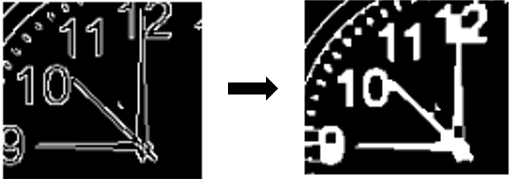

PRactic operatia de inchidere este formata din aplicarea operatiei de dilatare (ce cauzeaza marirea obiectelor) urmata de operatia de erodare (pentru micsorarea obiectelor).

Text(0.5, 1.0, 'Functiile scrise de noi')

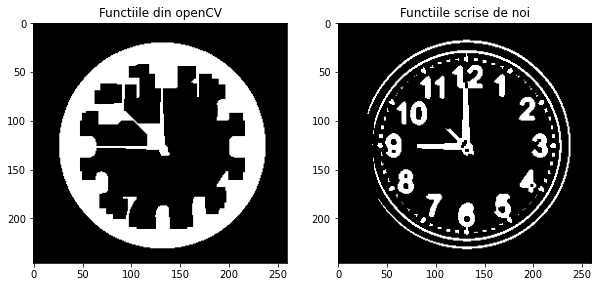

In [138]:
##### varianta 1 - folosind functiile din openCV ####
def morphImage(img, d = 11, e = 12):
    edges = cv.Canny(img,100,200)
    kernel = np.ones((d,d),np.uint8)
    kernel2 = np.ones((e,e),np.uint8)

    edges = cv.dilate(edges,kernel,iterations = 1)
    edges = cv.erode(edges,kernel2,iterations = 1)

    return edges

##### varianta 2 - functiile create de noi ####

# functie pentru extrage contururile folosind 
# gradientul pe veritcala si pe orizontala
def gradient(img):
    img_gray = color.rgb2gray(img)
    img_gray = img_gray * 255
    H, W = img_gray.shape
    
    img_out = np.zeros(img_gray.shape)
    for i in range(H-1):
        for j in range(W-1):
            dx = img_gray[i,j] - img_gray[i,j+1]
            dy = img_gray[i,j] - img_gray[i+1,j]
            img_out[i,j]= np.sqrt(dx**2+dy**2)
    return img_out

# filtru de mediere pentru eliminarea zgomotului 
# si netezirea contururilor
def avgFilter(img):
    h,w,ch = img.shape
    img_out = img.copy()
    mask = np.ones([3,3])/9
    
    for i in range(1,h -1):
        for j in range(1, w-1):
            for k in range(ch):
                val = np.sum((img[i-1:i+2, j-1:j+2, k] * mask))
                img_out[i, j , k] = val
    return img_out


# aplicam functiile descrise mai sus
def morphImage2(img):
    img = avgFilter(img)
    edges = gradient(img)
    edges[edges < 50] = 0
    edges[edges >= 150] = 255
    
    se1 = np.ones((1,5))
    se3 = np.ones((3,3))

    ## erodarea ##
    er_se1 = morpho.binary_erosion(edges, se3)
#     plt.imshow(er_se1,cmap='gray')
#     plt.title("Erodare")

    ## dilatare ##
    dil_se1 = morpho.binary_dilation(edges, se3)
#     plt.figure()
#     plt.imshow(dil_se1,cmap='gray')
#     plt.title("Dilatare")
    
    ## inchiderea ## (dilatare si apoi erodare)
    cl_3 = morpho.binary_erosion(dil_se1, se3)
#     plt.figure()
#     plt.imshow(cl_3,cmap='gray')
#     plt.title("Inchidere")
    edges[cl_3 == 0] = 0
    edges[cl_3 == True] = 255
    
    return edges.astype(np.uint8)
    
img = cv.imread('clock6.jpg')
edges1 = morphImage(img)
edges2 = morphImage2(img)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(edges1, cmap='gray')
plt.title("Functiile din openCV")

plt.subplot(1,2,2)
plt.imshow(edges2, cmap='gray')
plt.title("Functiile scrise de noi")


# 2. Detectia limbilor ceasului

Pentru a realiza acest pas folosim transformata Hough, o tehnica pentru a detecta diverse forme care pot fi descrise matematic.
Folosind acesta transformata:

- **extragem toate liniile din imagine**
- **le sortam descrescator in functie de distanta**
- **presupunand ca imaginile noastre nu au secundar alegem minutarul ca fiind linia cu dimensiunea maxima iar linia orelor a doua linie dupa distanta**
- **returnam coordonatele acestora**


## Hough Transform pentru linii

O linie este descrisa de ecuatia y = mx + c sau in forma parametrica ca 
ro = x cos(theta) + y sin(theta) => o imagine poate fi descrisa de doi paramterii (ro, theta) in care *ro* reprezinta distanta de la origine la dreapta iar *theta* este unghiul format de axa orizontala si perpendiculara la dreapta.

Primul pas pe care il realizeaza transformata Hough este sa creeze un spatiu 2D (numit **acumulator** - cu *ro* pentru linii si *theta* pentru coloane) pe care il seteaza initial cu valori de zero. Dimensiunea acestui spatiu influenteaza acuratetea transformarii. Daca se doreste o precizie a unghiurilor de 1 grad atunci spatiul va avea 180 de coloane. In cazul dimensiunii dormim sa putem sa detectam toate liniile care apar in imagine => dimensiunea maxima pe care poate sa o aiba o linie intr-o imagine este diagonala => acumulatorul va avea atatea randuri egale cu diagonala imaginii. 

Urmatorul pas este sa trecem prin fiecare pixel al imaginii. Pentru un pixel cunoastem coordonatele (x,y) ;i le introducem in ecuatia ro = x cos(theta) + y sin(theta) pentru fiecare valoare theta = 0,1,....180 incrementand perechile (ro, theta) din acumulator. Practic sistemul este un sistem de 'votare' a perechilor (ro, theta). La final, dupa parcurgerea tutoror pixelilor din imagine perechile cu cele mai multe voturi vor reprezenta liniile descoperite in imagine. De exemplu daca (50, 90) este perechea cu maximul de voturi => in imagine exista o linie la distanta de 50 fata de origine si la un unghi de 90 de grade. Acesta animatie exemplifica mai bine procesul(opencv24-python-tutorials.readthedocs.io) :


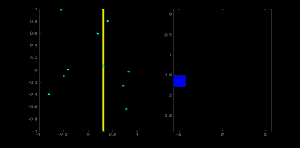


Alta varianta este Progressive Probabilistic Hough Transform, bazata pe presupunerea ca folosind un subset random de puncte de vot reprezinta o buna aproximare a rezultatului final + se pot extrage extremele dreptei in timpul procesului de votare traversand componentele conectate. In openCV aceasta functie primeste doi parametrii noi (pe langa dimensiunea spatiului si numarul de voturi minime) :

- minLineLength - lungimea minima a dreptei (orice dreapta cu lungimea mai mica va fi ignorata)
- maxLineGap - dimensiunea maxima a golului dintre segmente pentru ca accesta sa fie considerat o singura linie

**In acest proiect avem nevoie sa clasificam liniile gasite in functie de dimensiunea lor (pentru a determina linia orelor si a minutelor) => vom folosi HT probabilistica.**

## HT pentru cercuri

Pentru a descoperii cercurile din imagine se foloseste aceasi ideea -> trecem punctele din imaginea originala intr-un spatiu in care coordonatele sunt descrierea geometrica a cercului. Dar, deoarece cercurile sunt descrise de triplete de valori (x, y, raza) iar un spatiu 3D este ineficient folosim functia din openCV care foloseste o informatie alternativa : gradientul contururilor.


In [18]:
#functie ajutatoare pentru ordonarea doar in functie de distanta
def onlyDist(e):
    return e['dist']


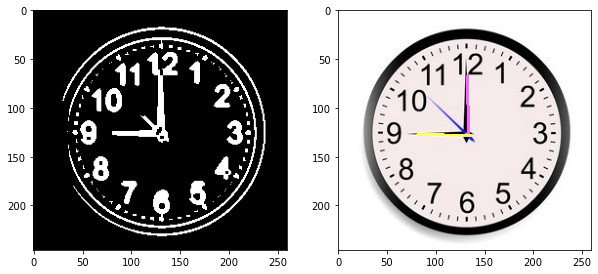

In [284]:
def getClockCoords(img, mode = 2, dilatare = 11, erodare = 12, show = 0):
    #aplicam operatiile de transformare asupra imaginii
    #edges = morphImage(img)
    if(mode == 2):
        edges2 = morphImage2(img)
    if(mode == 1):
        edges2 = morphImage(img, d=dilatare, e=erodare)
    
    
    
    #lines = array cu toate liniile gasite in imagine returnat de functia HT
    minLineLength = 1000
    maxLineGap = 11
    lines = cv.HoughLinesP(edges2,1,np.pi/180, 15 ,minLineLength,maxLineGap)
    
    #dict cu distantele liniilor 
    lines_dict=[]
    maxi = 0
    i = 0
    for line in lines:
        # pentru fiecare linie din lines ii calculam distanta si o adaugam in dictionar
        # de asemenea reprezentam toate liniile gasite pe imaginea originala (culoarea gri)
        x1, y1, x2, y2 = line[0]
        # decomentare pt reprezentarea tuturor liniilor
        #cv.line(img,(x1,y1),(x2,y2),(100,100,100),2)

        dist = np.sqrt( (x2 - x1)**2 + (y2 - y1)** 2)
        lines_dict.append({'dist':dist, 'index':i})
        i = i + 1

    # sortam dictionarul in ordine descrescatoare 
    # cea mai mare linie -> linia minutelor
    # a doua cea mai mare linie -> linia orelor
    lines_dict.sort(reverse=True,key=onlyDist)
    minutes_index = l[0]['index']
    hours_index = l[1]['index']

    xm1, ym1, xm2, ym2 = lines[minutes_index][0]
    xh1, yh1, xh2, yh2 = lines[hours_index][0]

    #reprezentam cu magenta minutele si cu galben linia orelor
    cv.line(img,(xm1,ym1),(xm2,ym2),(255,100,255),2)
    cv.line(img,(xh1,yh1),(xh2,yh2),(255,255,100),2)
    
    if(show == 1):
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(edges2, cmap='gray')

        plt.subplot(1,2,2)
        plt.imshow(img, cmap='gray') 
    
    hours = lines[hours_index][0]
    minutes = lines[minutes_index][0]
#     print(hours)
#     print(minutes)
    # returnam coord pt limbile ceasului
    return [hours, minutes]

img = cv.imread('clock6.jpg')
ret = getClockCoords(img, show=1)

## 3. Calculul efectiv al orei

1. determinam care sunt punctele extreme ale dreptelor (cele mai departe de centru)
2. calculam unghiurilor folosind teorema cosinusurilor (teorema pitagora generalizata)
3. folosind unghiurile calculam ora/minutele

**Pasul 1**

Dreapta este definita de doua puncte => pentru a determina care dintre ele exte extrema trebuie sa ne dam seama care este mai aproape de centrul imaginii. Vom calcula distanta de la punct la centrul imaginii si alegem ca extrema punctul care este mai departe. 

**Pasul 2**
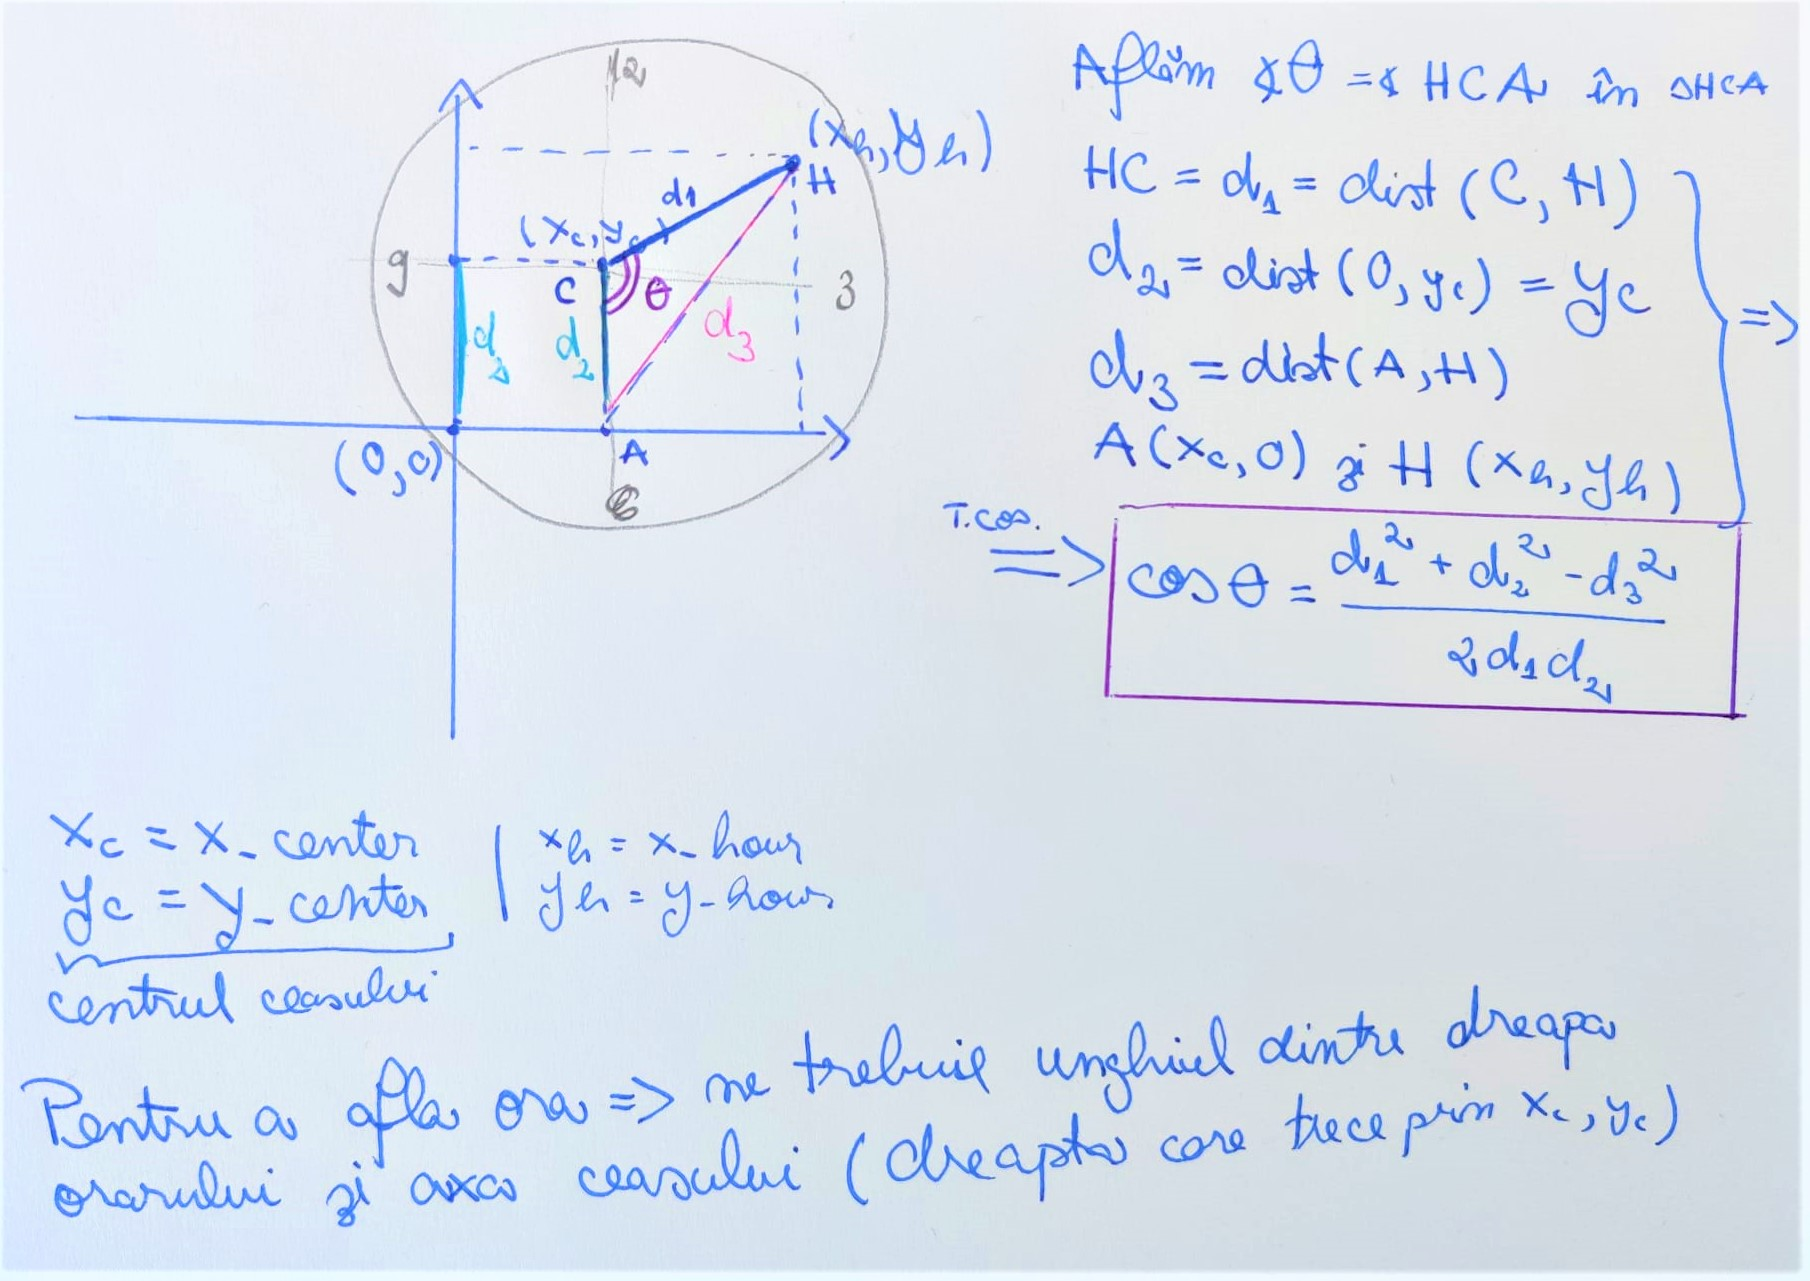

**Pasul 3**

Ceasul este un cerc => 360 de grade

Sunt 12 ore => *360 / 12ore* => *30 de grade* pentru fiecare ora

Pentru a afla ora impartim theta la 30 si extragem partea intreaga. (Daca ne aflam in partea stanga a ceasului orele trebuie puse "in oglinda")

Acelasi proces il repetam pentru minute, impartind la *360/60 = 6*

'9:01'

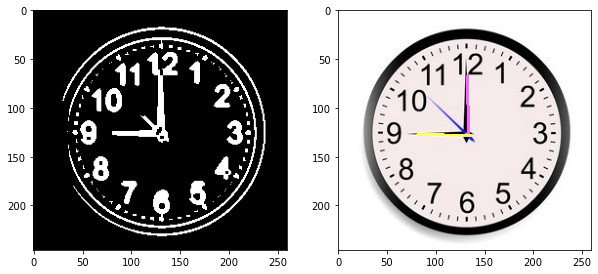

In [206]:
def read_clock(img, mode = 2, dilatare = 11, erodare = 12, show = 0):
    clock_coords = getClockCoords(img, mode = mode, 
                                  dilatare = dilatare, 
                                  erodare = erodare, 
                                  show = show)
    
    xh1, yh1, xh2, yh2 = clock_coords[0]
    xm1, ym1, xm2, ym2 = clock_coords[1]
    
    # originea = centrul imaginii
    width, height, ch = img.shape
    xcenter = int(width / 2)
    ycenter = int(height / 2)

    # calculam distantele fata de centru si alegem punctul cel mai departat
    dist_h1 = np.sqrt( (xcenter - xh1)**2 + (ycenter - yh1)** 2)
    dist_h2 = np.sqrt( (xcenter - xh2)**2 + (ycenter - yh2)** 2)
    
    if(dist_h1 > dist_h2):
        x_hour = xh1
        y_hour = yh1
    else:
        x_hour = xh2
        y_hour = yh2

    
    dist_m1 = np.sqrt( (xcenter - xm1)**2 + (ycenter - ym1)** 2)
    dist_m2 = np.sqrt( (xcenter - xm2)**2 + (ycenter - ym2)** 2)
    
    if(dist_m1 > dist_m2):
        x_minute = xm1
        y_minute = ym1
    else:
        x_minute = xm2
        y_minute = ym2
    
    #calculam unghiul theta pentru ore
    d1 = math.sqrt(((xcenter - x_hour)**2) + ((ycenter - y_hour)**2))
    d2 = ycenter
    d3 = math.sqrt(((xcenter - x_hour)**2) + ((0 - y_hour)**2))
    cos_theta = ( ((d1)**2)+ ((d2)**2) - ((d3)**2) ) / (2*(d1)*(d2))

    theta = math.acos(cos_theta)
    theta_hours = (theta * 180) / np.pi
#     print('theta_hours=' ,theta_hours)

    #calculam unghiul theta pentru minute
    d1 = math.sqrt(((xcenter - x_minute)**2) + ((ycenter - y_minute)**2))
    d2 = ycenter
    d3 = math.sqrt(((xcenter - x_minute)**2) + ((0 - y_minute)**2))
    cos_theta = ( ((d1)**2)+ ((d2)**2) - ((d3)**2) ) / (2*(d1)*(d2))

    theta = math.acos(cos_theta)
    theta_minutes = (theta * 180) / np.pi
    #print('theta_minutes=' ,theta_minutes)

    #Verificam in ce parte a ceasului ne aflam si calculam ora & minutele
    if(x_hour > xcenter):
        hours = (theta_hours / 30)
    else:
        hours = 12 - (theta_hours / 30)

    if(hours==0):
        hours=12
        
    hours_str = str(math.floor(hours))
    
    if(x_minute > xcenter):
        minutes = int(theta_minutes/6)
    else:
        minutes = 60 - int((theta_minutes/6))
    
    if(minutes==60):
        minutes=0
    
    #minutes = math.ceil(minutes)
    if(minutes < 10):
        minutes_str = "0" + str(minutes)
    else:
        minutes_str = str(minutes)
    

    
    out_str = hours_str + ":" + minutes_str
    return out_str


img = cv.imread('clock6.jpg')
read_clock(img, show = 1)

# Testare


Text(0.5, 1.0, '11:31')

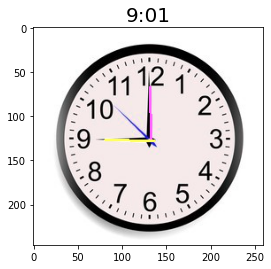

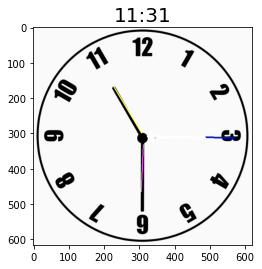

In [286]:
img = cv.imread('clock6.jpg')
title1 = read_clock(img)

plt.figure()
plt.imshow(img, cmap='gray')
plt.title(title1, fontsize=20)

img = cv.imread('ceas1.jpg')
title1 = read_clock(img, mode=1)

plt.figure()
plt.imshow(img, cmap='gray')
plt.title(title1, fontsize=20)


